In [1]:
cd ..

/tmp/ml-cost-function


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

from sklearn.compose import * 
from sklearn.preprocessing import *
from sklearn.feature_extraction import * 
from sklearn.feature_selection import *

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Pipeline

In [3]:
data = pd.read_csv('data/data.csv')
data

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION
0,0,Cash loans,F,N,N,0,103500.0,625536.0,26631.0,540000.0,Family,Working,Secondary / secondary special,Single / not married,Municipal apartment,0.032561,-14921,-3844,-602.0
1,0,Revolving loans,M,Y,Y,0,202500.0,292500.0,14625.0,292500.0,Unaccompanied,Commercial associate,Higher education,Single / not married,House / apartment,0.009657,-15458,-694,-9544.0
2,0,Cash loans,F,Y,Y,0,247500.0,1442596.5,46665.0,1129500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0.072508,-15603,-334,-3873.0
3,0,Cash loans,M,N,N,0,270000.0,545040.0,26509.5,450000.0,Family,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0.072508,-16392,-3015,-8902.0
4,0,Cash loans,M,Y,Y,0,450000.0,540000.0,56835.0,540000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.026392,-10941,-4026,-910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92248,0,Cash loans,M,N,Y,0,315000.0,331920.0,18135.0,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Single / not married,House / apartment,0.020246,-20301,365243,-23.0
92249,0,Cash loans,F,N,N,0,67500.0,339948.0,23656.5,315000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.019101,-22590,365243,-5105.0
92250,0,Cash loans,F,N,Y,0,45000.0,168102.0,9513.0,148500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.031329,-17920,-1837,-10196.0
92251,0,Cash loans,F,N,Y,0,315000.0,1188765.0,47272.5,1093500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0.010500,-15927,-944,-9938.0


In [4]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),

    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, make_column_selector(dtype_include=np.number)),
        ("cat", categorical_transformer, make_column_selector(dtype_exclude =np.number)),
    ]
)

In [5]:
X = data.drop(columns=['TARGET'])
y = data['TARGET']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [7]:
X_train

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION
34807,Cash loans,F,N,Y,0,360000.0,976500.0,26982.0,976500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0.007274,-18931,-286,-9761.0
20518,Cash loans,F,N,N,0,234000.0,485640.0,39069.0,450000.0,Unaccompanied,Working,Secondary / secondary special,Separated,Rented apartment,0.009175,-13382,-1257,-5874.0
46981,Cash loans,M,N,N,0,189000.0,1333179.0,74443.5,1260000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0.003069,-16185,-767,-3650.0
71313,Cash loans,F,N,Y,0,67500.0,738000.0,24520.5,738000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.018850,-20488,365243,-3974.0
68002,Cash loans,M,Y,N,0,112500.0,545040.0,34830.0,450000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-16932,-1872,-2851.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,Cash loans,F,N,Y,0,189000.0,454455.0,17262.0,319500.0,Family,Pensioner,Secondary / secondary special,Married,House / apartment,0.018850,-23193,365243,-1216.0
54886,Cash loans,M,Y,Y,0,202500.0,190764.0,11799.0,157500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.046220,-22039,-3912,-11280.0
76820,Revolving loans,M,Y,Y,0,135000.0,270000.0,13500.0,270000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.022625,-17451,-5332,-2185.0
860,Cash loans,F,N,Y,3,225000.0,1324440.0,47700.0,1170000.0,Unaccompanied,Commercial associate,Lower secondary,Married,House / apartment,0.019101,-12977,-2633,-4436.0


In [8]:
X_test

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION
37408,Cash loans,F,N,Y,0,126000.0,714915.0,31621.5,639000.0,Unaccompanied,Pensioner,Lower secondary,Married,House / apartment,0.046220,-23573,365243,-13083.0
75132,Cash loans,M,Y,N,2,247500.0,521280.0,27423.0,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.008866,-12191,-3298,-1371.0
21513,Cash loans,F,N,Y,0,202500.0,550467.0,20880.0,387000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0.035792,-11799,-586,-66.0
58291,Cash loans,F,N,N,0,225000.0,675000.0,34465.5,675000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010006,-19060,-962,-686.0
39033,Cash loans,F,N,Y,1,180000.0,254700.0,16582.5,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,Rented apartment,0.009175,-10092,-508,-330.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78085,Cash loans,F,N,N,0,112500.0,450000.0,27324.0,450000.0,Family,Working,Secondary / secondary special,Married,House / apartment,0.009175,-12365,-157,-694.0
15208,Cash loans,M,N,Y,0,90000.0,188460.0,9994.5,135000.0,Unaccompanied,Working,Higher education,Single / not married,House / apartment,0.022625,-15725,-3516,-5934.0
52877,Cash loans,M,Y,Y,0,216000.0,1314117.0,38551.5,1147500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.007020,-13348,-798,-1774.0
20663,Cash loans,F,N,Y,0,270000.0,315000.0,16213.5,315000.0,Unaccompanied,State servant,Higher education,Single / not married,House / apartment,0.072508,-17390,-2943,-5171.0


In [9]:
pipeline = Pipeline(
    [
        ('sampler', RandomUnderSampler()),
        ("transformer", preprocessor),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('estimator', LogisticRegression()),    
    ]
)

In [10]:
grid = GridSearchCV(pipeline, param_grid={}, cv=5, scoring='f1', n_jobs=-1, return_train_score=True, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampler', RandomUnderSampler()),
                                       ('transformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7feb34c11ff0>),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7feb34c12020>)])),
                                       ('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('estimator', LogisticRegression())]),
             n_jobs=-1, param_grid={}, return_train_score=True, scoring='f1',
             verbose=1)

In [11]:
def resultize(grid):

    res  = pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').head(5)
    columns = [k for k in res.columns  if "split" not in k ]
    res = res.loc[:, columns].round(2)
    return res

In [12]:
resultize(grid)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.42,0.04,0.14,0.03,{},0.2,0.01,1,0.21,0.0


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,rank_test_score
0,0.34,0.06,0.09,0.02,{},0.2,0.01,1


## First approch

In [28]:
def calcul_pnl_one_easy(montant, y_true, y_pred, taux=0.04, default_rate=1):

    if y_pred : # ==1
        return 0
    
    if y_true : 
        return -default_rate * montant

    return montant * taux

In [31]:
calcul_pnl_one_easy(100, 0, 0)

4.0

In [32]:
calcul_pnl_one_easy(100, 0, 1)

0

In [33]:
calcul_pnl_one_easy(100, 1, 0)

-100

In [34]:
calcul_pnl_one_easy(100, 1, 1)

0

In [35]:
y_pred_list = grid.predict(X_test)
y_pred_list 

array([0, 1, 1, ..., 1, 0, 1])

In [36]:
y_true_list = y_test.values
y_true_list

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
montant_list = X_test.loc[:, 'AMT_CREDIT'].values
montant_list

array([ 714915.,  521280.,  550467., ..., 1314117.,  315000.,  196677.])

In [40]:
v = 0
for m, y_true, y_pred in zip(montant_list, y_true_list, y_pred_list):
    v += calcul_pnl_one_easy(m, y_true=y_true, y_pred=y_pred)
v

-131095113.66000117

In [42]:
sum(montant_list)

16589585070.0

## 02 predict proba

In [43]:
y_pred_proba_list = grid.predict_proba(X_test)
y_pred_proba_list = list(y_pred_proba_list[ :, 0])
y_pred_proba_list = [round(x, 4) for x in y_pred_proba_list]
y_pred_proba_list

[0.6793,
 0.4779,
 0.3097,
 0.5413,
 0.2362,
 0.2987,
 0.6126,
 0.3666,
 0.4906,
 0.342,
 0.4468,
 0.5212,
 0.799,
 0.6959,
 0.4648,
 0.5055,
 0.6026,
 0.6651,
 0.5615,
 0.6404,
 0.7119,
 0.4338,
 0.5417,
 0.2971,
 0.8705,
 0.6669,
 0.5291,
 0.5503,
 0.3561,
 0.5309,
 0.4948,
 0.5296,
 0.5481,
 0.5353,
 0.4589,
 0.4632,
 0.627,
 0.5263,
 0.331,
 0.4802,
 0.4891,
 0.4715,
 0.6692,
 0.5331,
 0.7437,
 0.4267,
 0.4776,
 0.8395,
 0.4597,
 0.3467,
 0.7433,
 0.4144,
 0.384,
 0.5359,
 0.6246,
 0.5389,
 0.9202,
 0.5361,
 0.5113,
 0.2729,
 0.5912,
 0.2598,
 0.8082,
 0.5214,
 0.362,
 0.5894,
 0.4337,
 0.6032,
 0.4817,
 0.2915,
 0.6906,
 0.3777,
 0.5875,
 0.2985,
 0.7461,
 0.6628,
 0.7563,
 0.7012,
 0.603,
 0.431,
 0.7493,
 0.3158,
 0.4519,
 0.61,
 0.5806,
 0.7489,
 0.5395,
 0.4907,
 0.5155,
 0.3375,
 0.357,
 0.6596,
 0.3809,
 0.4131,
 0.4333,
 0.7858,
 0.5513,
 0.275,
 0.5101,
 0.5536,
 0.5697,
 0.721,
 0.6567,
 0.7294,
 0.4881,
 0.6035,
 0.4002,
 0.4402,
 0.4988,
 0.4883,
 0.5941,
 0.5351,
 0.41

In [73]:
def calcul_pnl_one_complexe(montant, 
                            y_true, 
                            y_pred_proba, 
                            taux=0.04, 
                            default_rate=0.25, 
                            threshold=0.5, ):


    y_pred = 0 if y_pred_proba > threshold else 1

    if y_pred : 
        return 0
    
    if y_true :
        return -default_rate* montant

    return montant * taux

In [74]:
v = 0
for m, y_true, y_pred_proba in zip(montant_list, y_true_list, y_pred_proba_list):
    v += calcul_pnl_one_complexe(m, y_true=y_true, y_pred_proba=y_pred_proba)
v

263280848.35499728

In [75]:
v = 0
for m, y_true, y_pred_proba in zip(montant_list, y_true_list, y_pred_proba_list):
    v += calcul_pnl_one_complexe(m, y_true=y_true, y_pred_proba=y_pred_proba,threshold=0.0)
v

303680259.8549948

In [76]:
v = 0
for m, y_true, y_pred_proba in zip(montant_list, y_true_list, y_pred_proba_list):
    v += calcul_pnl_one_complexe(m, y_true=y_true, y_pred_proba=y_pred_proba,threshold=1)
v

0

In [77]:
threshold_list = np.linspace(0, 1, 100)
pnl_list = []

for threshold in threshold_list:
    v = 0
    for m, y_true, y_pred_proba in zip(montant_list, y_true_list, y_pred_proba_list):
        v += calcul_pnl_one_complexe(m, y_true=y_true, y_pred_proba=y_pred_proba,threshold=threshold)
    pnl_list.append(v)

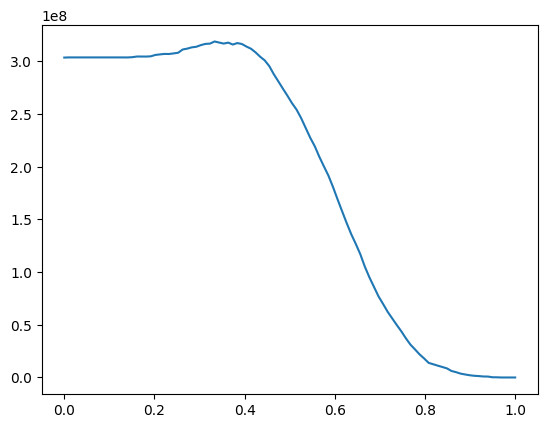

In [78]:
plt.plot(threshold_list, pnl_list)

In [79]:
import plotly.express as px


px.line(x=threshold_list, y=pnl_list)

## 03 With Good price

In [113]:
def calcul_pnl_one_goods(montant, 
                         good_price,
                            y_true, 
                            y_pred_proba, 
                            taux=0.03, 
                            loss_goods_rate=0.3,
                            threshold=0.5, ):


    y_pred = 0 if y_pred_proba > threshold else 1

    if y_pred : 
        return 0
    
    if y_true :
        value = (good_price * (1-loss_goods_rate)) -  montant
        return  value if value < 0 else 0

    return montant * taux

In [114]:
data.columns

Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION'],
      dtype='object')

In [115]:
goods_list = X_test.loc[:, 'AMT_GOODS_PRICE'].values
goods_list

array([ 639000.,  450000.,  387000., ..., 1147500.,  315000.,  184500.])

In [116]:
threshold_list = np.linspace(0, 1, 100)
pnl_list = []

for threshold in threshold_list:
    v = 0
    for m, g, y_true, y_pred_proba in zip(montant_list, goods_list, y_true_list, y_pred_proba_list):
        v += calcul_pnl_one_goods(m, g, y_true=y_true, y_pred_proba=y_pred_proba,threshold=threshold)
    pnl_list.append(v)

In [117]:
import plotly.express as px


px.line(x=threshold_list, y=pnl_list)